<a href="https://colab.research.google.com/github/johnyjchen/Google_Landmark_Recognition/blob/main/Final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preparation:


### (a) import libraries

In [1]:
from google.colab import files
from google.colab import drive
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os
import pandas as pd
import seaborn as sns
import sys, requests, shutil, os

### (b) Mount notebook to Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### (c) Import dataset

In [3]:
path = "/content/drive/My Drive/APM_B10/train.csv" #directory for data
df = pd.read_csv(path)

In [4]:
df.head()

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


In [5]:
df.shape

(1225029, 3)

In [6]:
data = df.copy()

# 2. EDA:


### (a) Sampling and data distribution

In [7]:
#Ref: https://towardsdatascience.com/google-landmark-recognition-using-transfer-learning-dde35cc760e1
#Sample only landmark_id from 1000-2000 to save time
landmark_list = [str(x) for x in list(range(1000,2000))]
data_sample = df[df['landmark_id'].isin(landmark_list)]

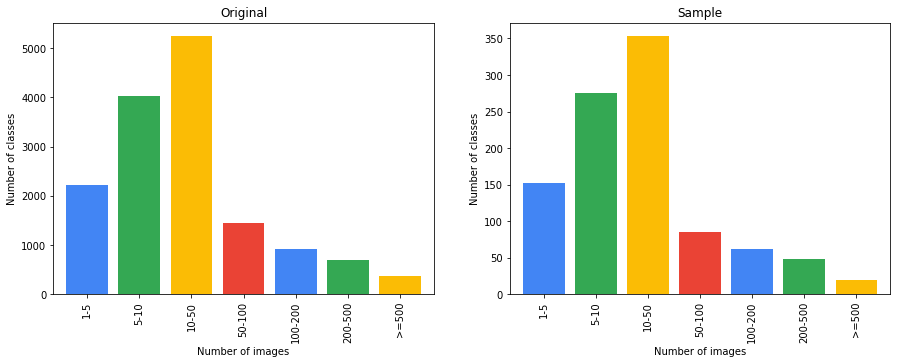

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import subplots

colors = np.array(['#4285f4','#34a853','#fbbc05','#ea4335'])
#Define the order in which to display the graph
order = ['1-5','5-10','10-50','50-100','100-200','200-500','>=500']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))


def plot_distribution(data_f, data_k, axis):
    # data['landmark_id'].value_counts()
    x=data_f.landmark_id.value_counts().index
    y=pd.DataFrame(data_f.landmark_id.value_counts())

    #Create a variable to group the number of image sin each class
    y['Number of images'] = np.where(y['landmark_id']>=500,'>=500',y['landmark_id'])
    y['Number of images'] = np.where((y['landmark_id']>=200) & (y['landmark_id']<500),'200-500',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=100) & (y['landmark_id']<200),'100-200',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=50) & (y['landmark_id']<100),'50-100',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=10) & (y['landmark_id']<50),'10-50',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=5) & (y['landmark_id']<10),'5-10',y['Number of images'])
    y['Number of images'] = np.where((y['landmark_id']>=0) & (y['landmark_id']<5),'1-5',y['Number of images'])

    y['Number of images'].value_counts().loc[order].plot(kind = 'bar',color = colors,width = 0.8, ax=axis)
    axis.set_xlabel('Number of images')
    axis.set_ylabel('Number of classes')
    axis.set_title(data_k)
    
plot_distribution(data, 'Original', ax1)
plot_distribution(data_sample, 'Sample', ax2)

Sample shows similar distribution as fullset of data.

### (b) Display one image

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
def display_image(url):
    img_style = "width: 500px; margin: 0px; float: left; border: 1px solid black;"
    image=f"<img style='{img_style}' src='{url}' />"
    display(HTML(image))

In [10]:
display_image(df['url'][150])

### (c) Further exploring and sampling

In [11]:
#how many images does each landmark have?
df['landmark_id'].value_counts()

9633    49465
6051    49238
None    33763
6599    22774
9779    18069
        ...  
8835        1
5575        1
6224        1
2952        1
5015        1
Name: landmark_id, Length: 14947, dtype: int64

In [12]:
#how many null values are there?
df.isnull().sum()

id             0
url            0
landmark_id    0
dtype: int64

In [13]:
#how many unqiue landmark class are there?
len(df['landmark_id'].unique())

14947

In [14]:
print("Number of classes under 100 occurences",(df['landmark_id'].value_counts() <= 100).sum(),
      'out of total number of categories',len(df['landmark_id'].unique()))

Number of classes under 100 occurences 12970 out of total number of categories 14947


In [15]:
#keeping only classes with 100 or more images, to guarantee 1% test split later.
filtered = df.groupby('landmark_id')['url'].filter(lambda x: len(x) >= 100)
df_filter = df[df['url'].isin(filtered)]

In [16]:
df_filter = df_filter.replace(to_replace='None', value=np.nan).dropna()
df_filter
#df_filter contains data without "None" as landmark_id AND only landmark_id with more than 100 urls

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
5,056708de792326b9,https://lh3.googleusercontent.com/-nbz_XT1dGz4...,5046
6,6ae1e206c579f649,https://lh6.googleusercontent.com/-onL5-pK9nZI...,5554
...,...,...,...
1225024,4bb5a501e5b26a6a,https://lh6.googleusercontent.com/-mRrQU3t5cYw...,9737
1225025,2cd8a404796cfe0e,https://lh6.googleusercontent.com/-0UB5gFx6w7M...,7758
1225026,8733b8b469fb8c1b,http://lh3.ggpht.com/-TDQWNVvJQDI/SI3HZSA4D3I/...,13170
1225027,14dd9e8790397c83,https://lh4.googleusercontent.com/-anV4Xpo0UuM...,5669


### (d) Preview mutiple images belong to same class

In [17]:
from IPython.display import Image
from IPython.core.display import HTML 

def display_category(urls):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(12).iteritems()])
    display(HTML(images_list))

In [18]:
category = df_filter['landmark_id'].value_counts().keys()[4]
urls = df_filter[df_filter['landmark_id'] == category]['url']
display_category(urls)

### (e) Final data sample

In [19]:
#Select only id from 1000-2000 to save time
landmark_list = [str(x) for x in list(range(1000,2000))] #changed from 1000-3000 to 2000
data_sample = df_filter[df_filter['landmark_id'].isin(landmark_list)]

In [20]:
#Save final sample as csv file to avoid re-running the above code everytime.
data_sample.to_csv('clean_data.csv', index=False)
files.download('clean_data.csv')
#Need to write read.csv function if needed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3. Downloading Images

### (a) Change URLs to resize images to target size

In [21]:
#Ref: https://www.kaggle.com/lyakaap/fast-resized-image-download-python-3
import re
TARGET_SIZE = 96 #imports images of resolution 96x96

def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)
    
    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)
    
    df = df[df.url.apply(lambda x: len(x.split('/'))>1)]
    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df

data_sample_resize = overwrite_urls(data_sample)
print ('1. URLs overwritten')

1. URLs overwritten


In [22]:
#Identify images URL with panoramio that's no longer supported by Google
bad_word='panoramio'
panoramio_list=[]
data_sample_resize['url']
for i in data_sample_resize['url']:
  if bad_word in i:
    panoramio_list.append(i)

In [23]:
new=pd.DataFrame(columns = ['id','url','landmark_id'])
new['url']=data_sample_resize['url'] == data_sample['url']
new['url'].value_counts()

False    45860
True      7494
Name: url, dtype: int64

### (b) Train-Test split

In [24]:
data_test = pd.DataFrame(columns = ['id','url','landmark_id'])
data_training_all = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_test = 0.01 #takes 1% from each class as holdout data

import random
random.seed(42)
for landmark_id in set(data_sample_resize['landmark_id']):
    n=1
    t = data_sample_resize[(data_sample_resize.landmark_id == landmark_id)] #get all images for a landmark id
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])  #create a list of all these images
        i += 1
        
    test = random.sample(r,int(percent_test*len(r))) #randomly pick a sample of 1% images from list 'r'
    training = list(set(r) - set(test))  #get the remaining images
    data_t = data_sample_resize[data_sample_resize.id.isin(test)] #holdout dataset
    data_tr = data_sample_resize[data_sample_resize.id.isin(training)] #training dataset
    data_test = data_test.append(data_t)  
    data_training_all = data_training_all.append(data_tr)
    n+=1

print ('2. train and test set created')

2. train and test set created


### (c) Train_Validation split

In [25]:
data_valid = pd.DataFrame(columns = ['id','url','landmark_id'])
data_train = pd.DataFrame(columns = ['id','url','landmark_id'])
percent_validation = 0.2 #takes 20% from each class as holdout data
import random
random.seed(42)
for landmark_id in set(data_training_all['landmark_id']):
    n=1
    t = data_training_all[(data_training_all.landmark_id == landmark_id)]
    i = 0
    r =[]
    while i < len(t.id):
        it = i
        r.append(t.id.iloc[it])
        i += 1
        
    valid = random.sample(r,int(percent_validation*len(r)))
    train = list(set(r) - set(valid)) 
    data_v = data_training_all[data_training_all.id.isin(valid)]
    data_t = data_training_all[data_training_all.id.isin(train)]
    data_valid = data_valid.append(data_v)
    data_train = data_train.append(data_t)
    n+=1

print ('3. train and validation set created')

3. train and validation set created


### (d) Check sizes after split

In [26]:
print (len(data_train))
print (len(data_valid))
print (len(data_test))

42355
10525
474


### (e) Downloading Images to existing folders in drive

Create directories 'N_train_images_model', 'M_validation_images_model', 'N_test_images_from_train' inside 'Data' folder before running the code below.



In [27]:
#function to fetch images
def fetch_image(path,folder):
    url=path
    response=requests.get(url, stream=True)
    path = '/content/drive/My Drive/APM_B10/'+ folder + '/image.jpg'
    with open(path, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response

In [ ]:
'''TRAIN SET - fetch images for the resized URLs and save in the already created directory train_images_model'''
i=0
for link in data_train['url']:              #looping over links to get images
    if os.path.exists('../Data/N_train_images_model/'+str(data_train['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'N_train_images_model')
    os.rename('/content/drive/My Drive/APM_B10/N_train_images_model/image.jpg','/content/drive/My Drive/APM_B10/N_train_images_model/'+ str(data_train['id'].iloc[i])+ '.jpg')
    i+=1
#     if(i==50):   #uncomment to test in machine speed
#         break 
print('4. train images fetched') 

In [ ]:
'''VALIDATION SET'''
i=0
for link in data_valid['url']:              #looping over links to get images
    if os.path.exists('../Data/M_validation_images_model/'+str(data_valid['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'M_validation_images_model')
    os.rename('/content/drive/My Drive/APM_B10/M_validation_images_model/image.jpg','/content/drive/My Drive/APM_B10/M_validation_images_model/'+ str(data_valid['id'].iloc[i])+ '.jpg')
    i+=1
#     if(i==50):   #uncomment to test in your machine #took only 30 min?
#         break
print('5. Validation images fetched')

5. Validation images fetched


In [ ]:
'''TEST SET'''
i=0
for link in data_test['url']:              #looping over links to get images
    if os.path.exists('../Data/N_test_images_from_train/'+str(data_test['id'].iloc[i])+'.jpg'):
        i+=1
        continue
    fetch_image(link,'N_test_images_from_train')
    os.rename('/content/drive/My Drive/APM_B10/N_test_images_from_train/image.jpg','/content/drive/My Drive/APM_B10/N_test_images_from_train/'+ str(data_test['id'].iloc[i])+ '.jpg')
    i+=1
    # if(i==10):   #uncomment to test in your machine
    #     break
print('6. Test images fetched') 

6. Test images fetched


# 4. Processing Downloaded Images

In [29]:
#Data1 to be checked upon for next steps
optimal_range = [str(x) for x in list(range(1000,2000))]
data1 = df_filter[df_filter['landmark_id'].isin(optimal_range)]

### (a) Function to create folders for each class within train, valid, and test

In [30]:
import pandas as pd
import os
import shutil
from shutil import copyfile
import urllib

def createfolders(dataset,folder):
    i = 0
    while i < len(dataset):
        landmark = str(dataset.landmark_id.iloc[i])
        path = '/content/drive/My Drive/APM_B10/' + folder + '/'+ landmark
        if not os.path.exists(path):
            os.makedirs(path)
        i+=1

### (b) Function to get rid of images with broken links (small sizes)

In [31]:
def transformdata(data,path1, path2):
    n = 1
    for landmark_id in set(data['landmark_id']):
        t = data[(data.landmark_id == landmark_id)]
        i = 1
        r =[]
        while i <= len(t.id):
            it = i - 1
            r.append(t.id.iloc[it])
            i += 1
        for files in os.listdir(rootdirpics):    # loop through startfolders
            inpath = path1 + files
            folder = str(landmark_id)
            outpath = path2 + folder  
            if ((files.split('.')[0] in r) & (os.path.getsize(inpath) >1000)):
                print(outpath)
                shutil.move(inpath, outpath)
            elif ((files.split('.')[0] in r) & (os.path.getsize(inpath) <= 1000)):
                os.remove(inpath) #delets small files that cannot be images
        n+=1

### (c) Training Set

In [ ]:
temp = pd.DataFrame(data_train.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

#make folders for landmark ID which had no images in validation sets
available = [int((x[0].split('/'))[-1]) for x in os.walk(r'../Data/M_validation_images_model/') if len((x[0].split('/'))[-1]) > 0]
new = [str(x) for x in range(1000,2999) if x not in available]
for i in new:
    path = '../Data/N_validation_images_model/' + i
    if not os.path.exists(path):
        os.makedirs(path)

createfolders(temp,'N_train_images_model')

In [ ]:
rootdirpics = r'/content/drive/My Drive/APM_B10/N_train_images_model/'
rootdirfolders = r'/content/drive/My Drive/APM_B10/N_train_images_model/'

transformdata(data1,rootdirpics, rootdirfolders)
print ('Train images moved')

### (d) Validation Set

In [ ]:
temp = pd.DataFrame(data_valid.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

createfolders(temp,'M_validation_images_model')

In [ ]:
rootdirpics = r'/content/drive/My Drive/APM_B10/M_validation_images_model/'
rootdirfolders = r'/content/drive/My Drive/APM_B10/M_validation_images_model/'

transformdata(data1,rootdirpics, rootdirfolders)
print ('Vaidation images moved')

### (e) Test Set

In [ ]:
temp = pd.DataFrame(data_test.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

createfolders(temp,'N_test_images_from_train')

In [ ]:
rootdirpics = r'/content/drive/My Drive/APM_B10/N_test_images_from_train/'
rootdirfolders = r'/content/drive/My Drive/APM_B10/N_test_images_from_train/'

transformdata(data1,rootdirpics, rootdirfolders)
print ('Test images moved')

###(f) Further cleaning to remove images in html that models cannot read

In [ ]:
#TRAIN
train_n_dir = r'/content/drive/My Drive/APM_B10/N_train_images_model/'
train_n_landmark_list = []
for i in os.listdir(validation_dir):
  train_n_landmark_list.append(i)
#train_n_landmark_list

In [ ]:
from keras.preprocessing import image #IMPORTANT, all images would be removed otherwise

for landmark in train_n_landmark_list:
  for i in os.listdir(train_n_dir + landmark):
    try:
      image.load_img(train_n_dir + landmark + '/' + i)
    except:
      train_n_html.append(train_n_dir + landmark + '/' + i)
      print(train_n_dir + landmark + '/' + i)
      os.remove(train_n_dir + landmark + '/' + i)

Run through each image in each sub-folder within the set.
Remove the image if it cannot be displayed.

In [ ]:
#VALID
validation_dir = r'/content/drive/My Drive/APM_B10/M_validation_images_model/'
valid_n_landmark_list = []
for i in os.listdir(validation_dir):
  valid_n_landmark_list.append(i)
#valid_n_landmark_list

In [ ]:
for landmark in valid_n_landmark_list:
  for i in os.listdir(validation_dir + landmark):
    try:
      image.load_img(validation_dir + landmark + '/' + i)
    except:
      valid_n_html.append(validation_dir + landmark + '/' + i)
      print(validation_dir + landmark + '/' + i)
      os.remove(validation_dir + landmark + '/' + i)

In [ ]:
#TEST
test_n_dir = r'/content/drive/My Drive/APM_B10/N_test_images_from_train/'
test_n_landmark_list = []
for i in os.listdir(test_n_dir):
  test_n_landmark_list.append(i)
#test_n_landmark_list

In [ ]:
for landmark in test_n_landmark_list:
  for i in os.listdir(test_n_dir + landmark):
    try:
      image.load_img(test_n_dir + landmark + '/' + i)
    except:
      test_n_landmark_list.append(test_n_dir + landmark + '/' + i)
      print(test_n_dir + landmark + '/' + i)
      os.remove(test_n_dir + landmark + '/' + i)

# 5. Preparation for Modeling

### See next script file